# The Expanding Universe - UW Grad Class

### Polls: https://pollev.com/davidjones791

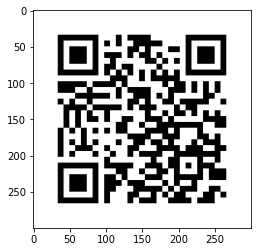

In [1]:
## preliminaries

import casjobs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
Simbad.add_votable_fields('flux(H)')
from astroquery.mast import Catalogs
import numpy as np
import astropy.table as at
from astroquery.ipac.ned import Ned
from scipy.optimize import minimize
from scipy import stats
%matplotlib inline

img = mpimg.imread('pollev.png',format='url')
imgplot = plt.imshow(img)

## 1. Olber's Paradox

### Is the Universe isotropic/homogeneous?

Let's query GALEX for galaxies as a function of Galactic longitude and latitude

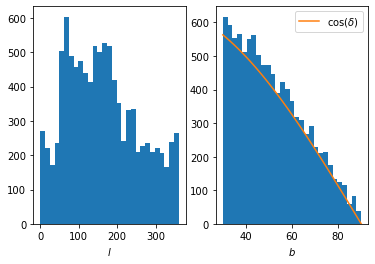

In [2]:
jobs = casjobs.CasJobs(userid=892987546,
                       password=open('psswd.txt').readlines()[0].replace('\n',''),
                       base_url='http://galex.stsci.edu/CasJobs/services/jobs.asmx')

query = """SELECT TOP 10000 objID, glon, glat
FROM PhotoObjAll
WHERE
glat > 30 AND fuv_mag > 19 AND fuv_mag < 20
ORDER BY RAND()"""

job_output = jobs.quick(query,context='Galex_GR6Plus7',task_name='galex_uw')
l,b = [],[]
for j in job_output.split('\n')[1:]:
    if len(j):
        l += [float(j.split(',')[1])]
        b += [float(j.split(',')[2])]

lbins = np.linspace(0,360,30)
bbins = np.linspace(30,90,30)
ax1 = plt.subplot(121); ax2 = plt.subplot(122)
ax1.hist(l,bins=lbins)
ax1.set_xlabel('$l$')
ax2.hist(b,bins=bbins)
ax2.set_xlabel('$b$')
b_test = np.linspace(30,90,100)
ax2.plot(b_test,np.cos(b_test*np.pi/180)*650,label='cos($\delta$)')
ax2.legend()

## 2. Measuring the Hubble Constant

### Standard Approach

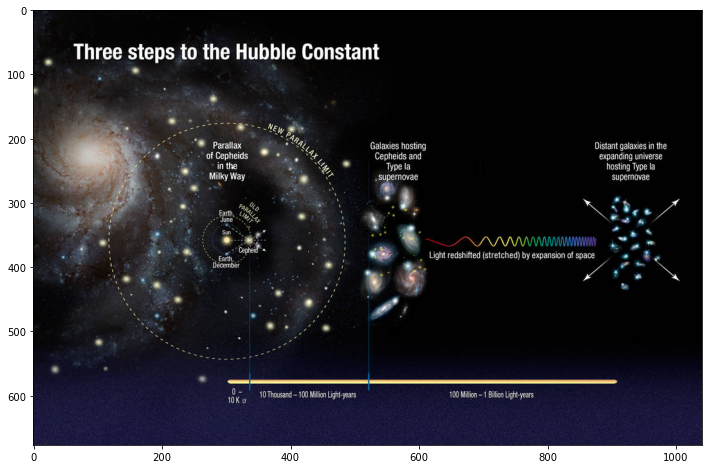

In [3]:
plt.rcParams['figure.figsize'] = (14,8)
img = mpimg.imread('h0_distance_ladder.jpeg')
imgplot = plt.imshow(img)

### Simplified (Two-Rung) Approach
Lets use Cepheids (like Hubble did) to measure the Hubble constant.  The steps are 1) use Gaia to get distances for Cepheids in the Milky Way, 2) Get Cepheid magnitudes from SH0ES, 3) simultaneously calibrate the luminosity of Cepheids in galaxies at ~40 Mpc and measure the expansion rate.

In [4]:
## A Few Gaia Cepheids (subset from SH0ES+21)
Cepheids = ['XX CAR','XY CAR','XZ CAR','YZ CAR','VW CEN','VY CAR','VZ PUP','WZ SGR','X CYG']
Log_Periods_MW = [1.196,1.095,1.221,1.259,1.177,1.276,1.365,1.339,1.214]
## query the distances
cepheid_mw_mags,mu_gaia = np.array([]),np.array([])
cepheid_mw_mag_err,mu_gaia_err = np.array([]),np.array([])
for c in Cepheids:
    # get RA/Dec
    result_table = Simbad.query_object(c)    
    coord = SkyCoord(ra=result_table['RA'][0], dec=result_table['DEC'][0], unit=(u.hour, u.degree), frame='icrs')
    cepheid_mw_mags = np.append(cepheid_mw_mags,result_table['FLUX_H'][0])
    cepheid_mw_mag_err = np.append(cepheid_mw_mag_err,[0.1]) # Simbad mags are probably fairly uncertain
    
    # Gaia Query
    width = u.Quantity(5, u.arcsec)
    height = u.Quantity(5, u.arcsec)
    r = Gaia.query_object_async(coordinate=coord, width=width, height=height)
    distance = 1/(r['parallax'][0]*1e-3)
    mu = 5*np.log10(distance) - 5
    mu_gaia = np.append(mu_gaia,mu)
    mu_gaia_err = np.append(mu_gaia_err,[0])

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


20 43 24.1917 +35 35 16.077


/var/folders/gb/ltvsdtcj74j7xf7pyycyvf7r000g2p/T/ipykernel_97356/1323459056.py:3: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = mpimg.imread(img_url,format='url')


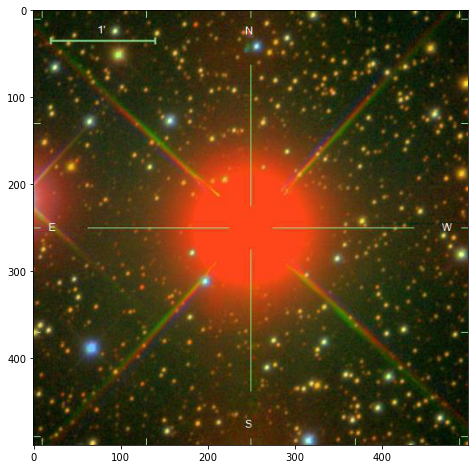

In [5]:
img_url = f"http://skyservice.pha.jhu.edu/DR14/ImgCutout/getjpeg.aspx?ra={coord.ra.deg}&dec={coord.dec.deg}&scale=0.5&width=500&height=500&opt=G&query=&Grid=on" 
print(result_table['RA'][0],result_table['DEC'][0])
img = mpimg.imread(img_url,format='url')
imgplot = plt.imshow(img)

Now we need Cepheid magnitudes from other galaxies for comparison.  This time we have to get something from the literature, just for the sake of time:

In [6]:
# SH0ES+22 Data
data = at.Table.read('sh0es_table2.tex',format='latex',data_start=1,header_start=0)

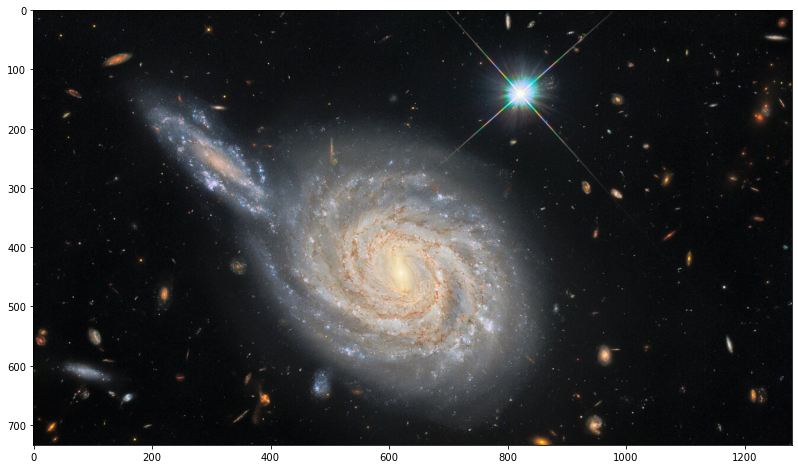

In [7]:
# Redshifts for all our galaxies
galaxies = ['NGC 105','NGC 976','NGC 3147','NGC 5468','NGC 5728','NGC 7329','NGC 7678']
redshifts = []
for g in galaxies:
    result_table = Ned.query_object(g) 
    redshifts += [result_table['Redshift'][0]]

plt.rcParams['figure.figsize'] = (14,8)
img = mpimg.imread('ngc_105.jpeg')
imgplot = plt.imshow(img)

### Setting up the Data

In [8]:
# data for equation 1
cepheid_mags,cepheid_mag_err,z,periods = np.array([]),np.array([]),np.array([]),np.array([])
for g,r in zip(galaxies,redshifts):
    iTable = data['Field'] == g.replace('GC ','').replace('105', '105A') ## shorthand galaxy names
    cepheid_mags = np.append(cepheid_mags,data['$F160W$'][iTable])
    cepheid_mag_err = np.append(cepheid_mag_err,data['F160W_sigma_tot'][iTable])
    z = np.append(z,[r]*len(data[iTable]))
    periods = np.append(periods,data['P'][iTable])
# data for equation 2 is above

### Constructing the Likelihood

In [9]:
# negative log likelihood, which we will *minimize*
def lnlike(x):
    logH0,M = x[:]
    
    # equation 1
    cepheid_model_mags = M - 5*logH0 + 5*np.log10(3e5*z) + 25
    chi2_1 = (cepheid_mags - cepheid_model_mags)**2./cepheid_mag_err**2.
    
    # equation 2
    chi2_2 = (cepheid_mw_mags - mu_gaia - M)**2/(cepheid_mw_mag_err**2 + mu_gaia_err**2.)
    
    return np.sum(np.append(chi2_1,chi2_2)/2)

### Estimating the parameters

In [10]:
### just some basic code, plot up the posterior
### maximuze the log likelihood
md = minimize(lnlike,(1,-3))
h0_err = 10**(md.x[0])*np.log(10)*np.sqrt(md.hess_inv[0,0])
print(f'H_0 = {10**(md.x[0]):.1f} +- {h0_err:.1f} km/s/Mpc')
print(md.message)

H_0 = 135.9 +- 3.0 km/s/Mpc
Optimization terminated successfully.


### Correcting for Biases

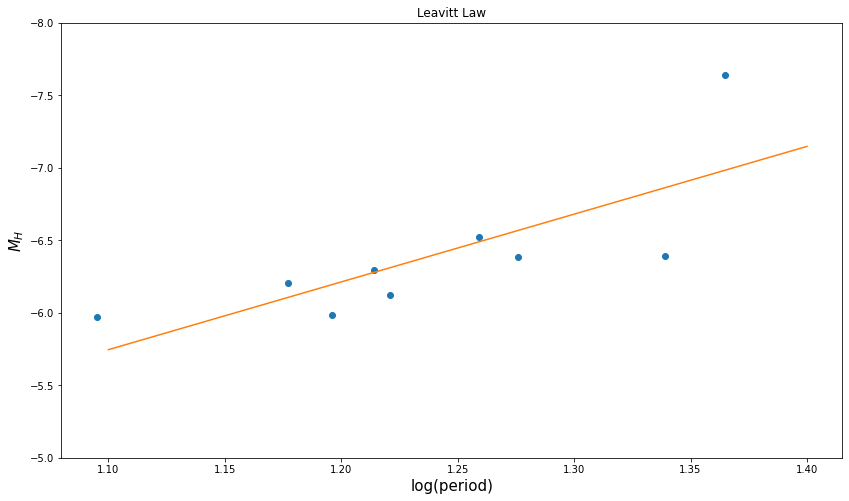

In [11]:
### Period versus luminosity relation
plt.plot(Log_Periods_MW,cepheid_mw_mags-mu_gaia,'o')
plt.xlabel('log(period)',fontsize=15)
plt.ylabel('$M_H$',fontsize=15)
plt.title('Leavitt Law')
plt.ylim([-5,-8])
slope, intercept, r_value, p_value, std_err = stats.linregress(Log_Periods_MW,cepheid_mw_mags-mu_gaia)
logP = np.linspace(1.1,1.4,100)
plt.plot(logP,slope*logP+intercept)

In [12]:
### and let's just do a basic correction for the P-L
mag_offset = -3.3*(np.median(np.log10(periods)) - np.median(Log_Periods_MW))

def lnlike(x):
    logH0,M = x[:]
    
    # equation 1
    cepheid_model_mags = M - 5*logH0 + 5*np.log10(3e5*z) + 25
    chi2_1 = (cepheid_mags-mag_offset - cepheid_model_mags)**2./cepheid_mag_err**2.
    #mag_offset
    # equation 2
    chi2_2 = (cepheid_mw_mags - mu_gaia - M)**2/(cepheid_mw_mag_err**2 + mu_gaia_err**2.)
    
    return np.sum(np.append(chi2_1,chi2_2)/2)

md = minimize(lnlike,(1,-3))
h0_err = 10**(md.x[0])*np.log(10)*np.sqrt(md.hess_inv[0,0])
print(f'H_0 = {10**(md.x[0]):.1f} +- {h0_err:.1f} km/s/Mpc')
print(md.message)

H_0 = 67.3 +- 1.5 km/s/Mpc
Optimization terminated successfully.
